# DeepExplain example for PTB-XL data

This is an example of applying xAI attribution methods, such as Gradient*Input, Integrated Gradients, LRP and DeepLIFT to medical signals (ECG) from [PTB-XL dataset](https://physionet.org/content/ptb-xl/1.0.0/). DeepExplain framework from [https://github.com/marcoancona/DeepExplain](https://github.com/marcoancona/DeepExplain) was used to explaine classification results.

In [ ]:
!pip install h5py==2.9.0

In [ ]:
!pip install wfdb

In [ ]:
!pip install -e git+https://github.com/marcoancona/DeepExplain.git#egg=deepexplain

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np
import wfdb
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import model_from_json, load_model, Model
from tensorflow.keras import backend as K

In [ ]:
import tempfile, sys, os
sys.path.insert(0, os.path.abspath('..'))

# Import DeepExplain
from src.deepexplain.deepexplain.tensorflow import DeepExplain

# Interpretation results

For classification two network architectures were used: [U-Net](https://arxiv.org/abs/1910.11162) and [ResNet](https://arxiv.org/abs/1611.06455).

In [ ]:
def deep_explain(model, x_test, y_test):
    with DeepExplain(session=K.get_session()) as de:
        input_tensor = model.layers[0].input

        fModel = Model(inputs=input_tensor, outputs = model.layers[-1].output)
        target_tensor = fModel(input_tensor)
        
        attributions_gradin = de.explain('grad*input', target_tensor, input_tensor, x_test, ys=y_test)
        attributions_ig =     de.explain('intgrad', target_tensor, input_tensor, x_test, ys=y_test)
        attributions_dl =     de.explain('deeplift', target_tensor, input_tensor, x_test, ys=y_test)
        attributions_elrp =   de.explain('elrp', target_tensor, input_tensor, x_test, ys=y_test)

    attribution_dict = {'Gradient*Input': attributions_gradin, 
                   'Integrated Gradients': attributions_ig, 
                   'DeepLIFT': attributions_dl, 
                   'LRP': attributions_elrp}

    return attribution_dict

In [ ]:
def get_test_samples(dataframe, n_ecg, n_classes):
    y_test = dataframe.iloc[n_ecg-1, -n_classes:]
    y_test = y_test.to_numpy()
    y_test = y_test.reshape(1, y_test.shape[0])

    data = [wfdb.rdsamp('/data/' + str(Y.iloc[n_ecg-1, 25]) )]
    X_test = np.array([signal for signal, meta in data])

    return X_test, y_test

In [ ]:
def get_predict_class_and_score(y_pred, classes):
    id_prediction = np.argmax(y_pred)
    prediction_class = classes[id_prediction]
    score = np.max(y_pred)
    print('prediction class:', prediction_class, ', score:', score)
    return prediction_class, score

In [ ]:
def interpretation(attributions, x_test, all_leads, lead, pred_class, score, n_ecg, model_type):
    lead_idx = all_leads.index(lead)

    if model_type == 'resnet':
        x_data = x_test[0, 0, :, lead_idx]
    elif model_type == 'unet':
        x_data = x_test[0, :, 0, lead_idx]
    x_df = pd.Series(x_data)

    fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(28, 14))
    axes = [ax0, ax1, ax2, ax3]
    idx_axes = 0

    for attr_name, attributes in attributions.items():
        axes[idx_axes].plot(x_df, color="black")
        axes[idx_axes].set_xlabel('')
        axes[idx_axes].set_ylabel('')
        axes[idx_axes].set_title('')
        axes[idx_axes].grid(False)

        num_of_colors = 20

        if model_type == 'resnet':
            attr_data = attributes[0, 0, :, lead_idx]
        elif model_type == 'unet':
            attr_data = attributes[0, :, 0, lead_idx]
        min_attr = min(attr_data)
        max_attr = max(attr_data)
        states_min = list(np.linspace(min_attr, 0, num=int(num_of_colors/2), endpoint=False))
        states_max = list(np.linspace(0, max_attr, num=int(num_of_colors/2)))
        states_int = states_min + states_max

        attr_data_df = pd.Series(attr_data)
        state = pd.cut(
            attr_data_df, bins=states_int, labels=range(num_of_colors-1)
        )

        cmap = plt.get_cmap('RdBu_r')
        trans = mtransforms.blended_transform_factory(axes[idx_axes].transData, axes[idx_axes].transAxes)

        for i, color in enumerate(cmap(np.linspace(0, 1, (num_of_colors-1)+2)[1:-1])):
            axes[idx_axes].fill_between(np.arange(0, 1000), 0, 1, where=state == i,
                            facecolor=color, transform=trans, linewidth=6,     
                        edgecolor=color, alpha=0.6)
            axes[idx_axes].minorticks_on()
            axes[idx_axes].xaxis.set_ticks(np.arange(0, 1000, 50))
            axes[idx_axes].grid(which='minor')
            axes[idx_axes].grid(which='major')
        
        axes[idx_axes].set_ylabel(lead)
        axes[idx_axes].set_title('Diagnosis: ' + pred_class + ', Score: ' + str(np.round(score, 2)) + ', Method: ' + attr_name, fontdict={'fontsize': 18})
        idx_axes += 1
    plt.show()
    fig.savefig(str(n_ecg)+'_'+str(pred_class)+'_'+str(lead)+'_'+model_type)

## 6 classes

Networks were trained to classify one of six classes: NORM, STTC, MI, HYP, CD, Unknown.

In [ ]:
Y = pd.read_csv('ptbxl_diagnostic_classes.csv', index_col='ecg_id')
Y_dummies = pd.get_dummies(Y['diagnosis'])
Y = pd.concat((Y, Y_dummies), axis=1)

n_classes = 6

classes = list(Y.columns)[-n_classes:]
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [ ]:
n_ecg = 1009

### ResNet

In [ ]:
model = load_model('/models/resnet_elu.h5')

In [ ]:
x_test, y_test = get_test_samples(Y, n_ecg, n_classes)

x_test_reshaped = x_test.reshape(1, x_test.shape[0], x_test.shape[1], x_test.shape[2])
y_pred = model.predict(x_test_reshaped, verbose=0)

pred_class, score = get_predict_class_and_score(y_pred, classes)

prediction class: STTC , score: 0.8660534


In [ ]:
%%time
attr = deep_explain(model, x_test_reshaped, y_test)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


CPU times: user 52.7 s, sys: 1.24 s, total: 53.9 s
Wall time: 32.8 s


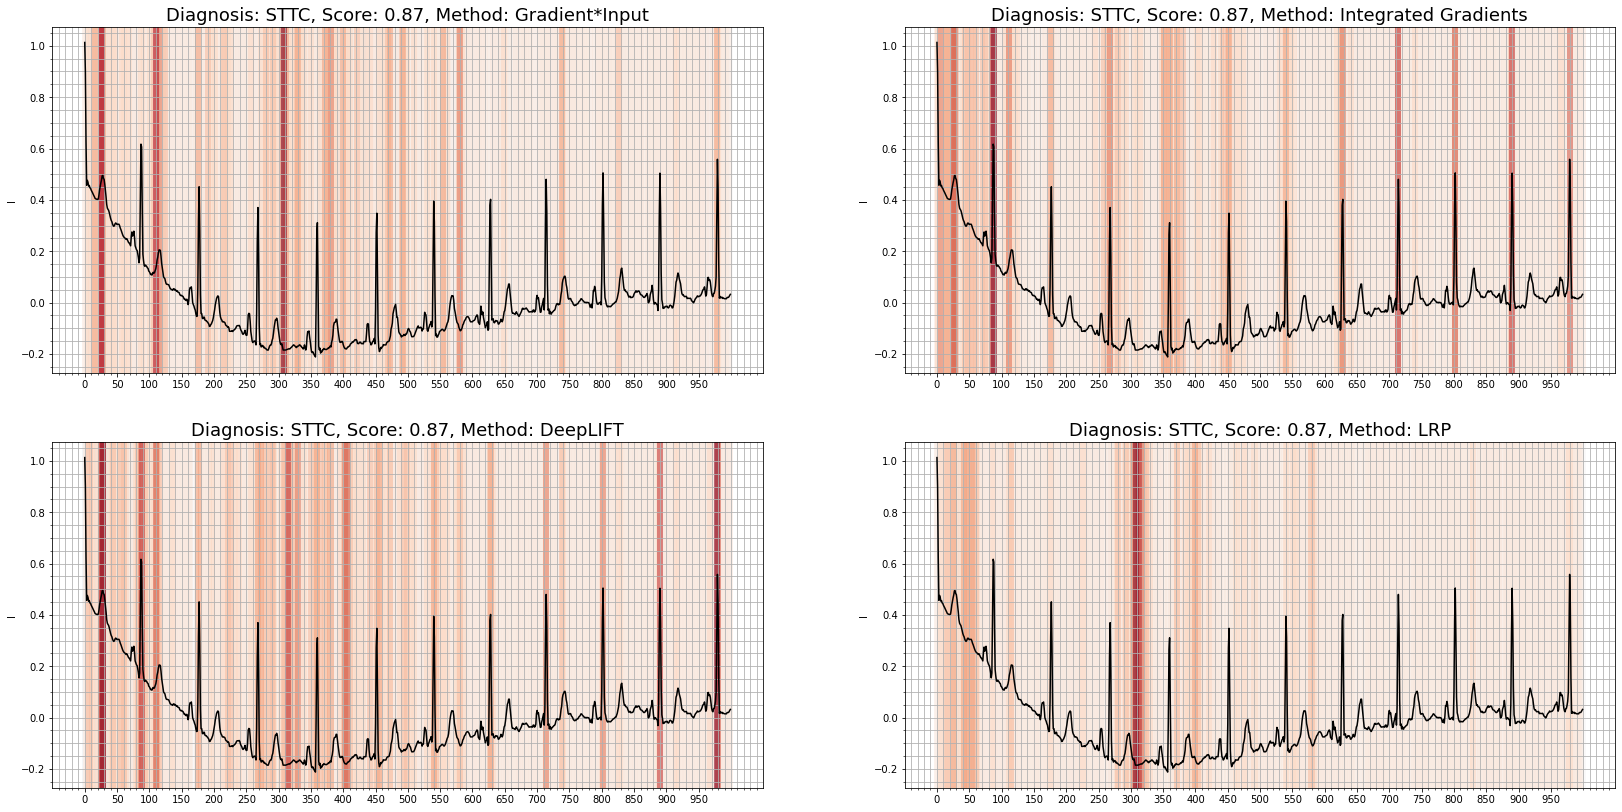

CPU times: user 3.72 s, sys: 208 ms, total: 3.93 s
Wall time: 3.77 s


In [ ]:
%%time
interpretation(attr, x_test_reshaped, leads, 'I', pred_class, score, n_ecg, 'resnet')

### U-Net

In [ ]:
model = load_model('/models/unet_relu.h5')

In [ ]:
x_test, y_test = get_test_samples(Y, n_ecg, n_classes)

x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1], 1, x_test.shape[2])
y_pred = model.predict(x_test_reshaped, verbose=0)

pred_class, score = get_predict_class_and_score(y_pred, classes)

attr = deep_explain(model, x_test_reshaped, y_test)

prediction class: STTC , score: 0.4731459


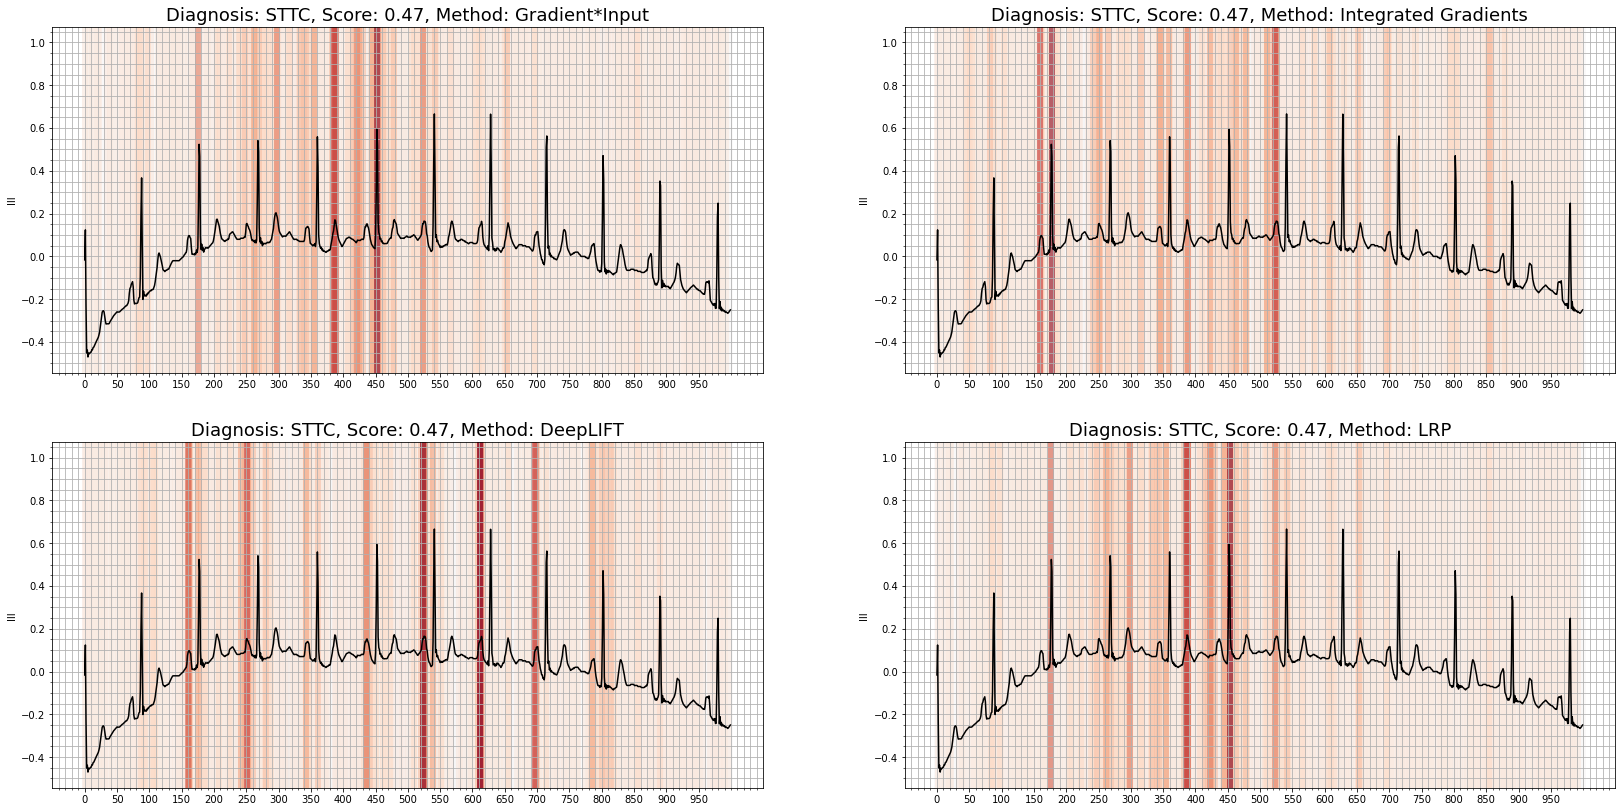

In [ ]:
interpretation(attr, x_test_reshaped, leads, 'III', pred_class, score, n_ecg, 'unet')

## 44 classes

Networks were trained to classify one of 44 classes: NDT, NST_, DIG, LNGQT, IMI, ASMI, etc.

In [ ]:
Y = pd.read_csv('ptbxl_diagnostic_classes_diags_vals.csv', index_col='ecg_id')
Y_dummies = pd.get_dummies(Y['diagnosis_class'])
Y = pd.concat((Y, Y_dummies), axis=1)

n_classes = 44

classes = list(Y.columns)[-n_classes:]
leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [ ]:
n_ecg = 93

### ResNet

In [ ]:
model = load_model('/models/resnet_elu_44.h5')

In [ ]:
x_test, y_test = get_test_samples(Y, n_ecg, n_classes)

x_test_reshaped = x_test.reshape(1, x_test.shape[0], x_test.shape[1], x_test.shape[2])
y_pred = model.predict(x_test_reshaped, verbose=0)

pred_class, score = get_predict_class_and_score(y_pred, classes)

attr = deep_explain(model, x_test_reshaped, y_test)

prediction class: NORM , score: 0.7032055


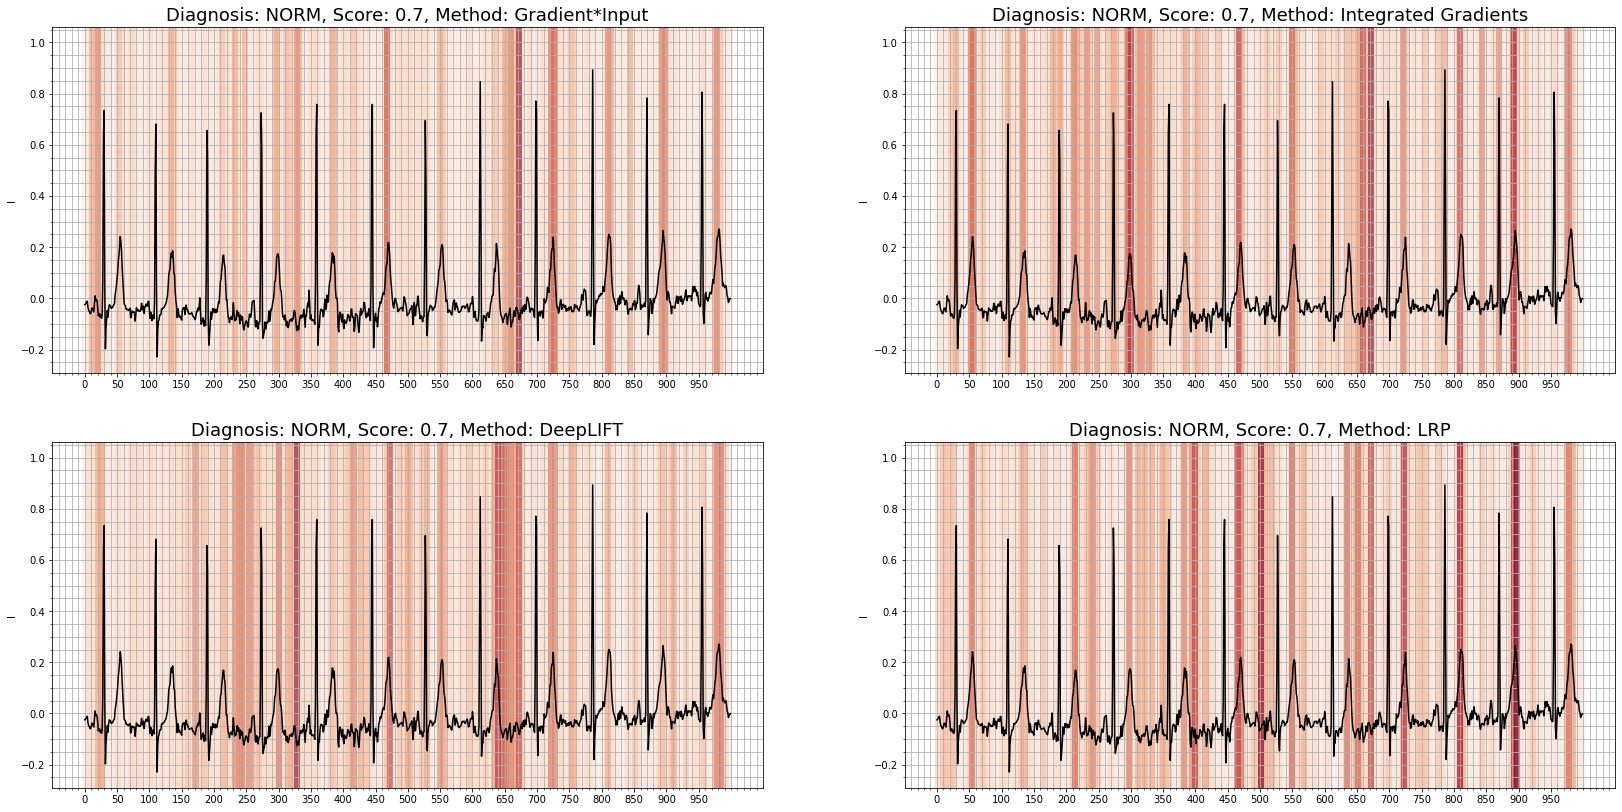

In [ ]:
interpretation(attr, x_test_reshaped, leads, 'I', pred_class, score, n_ecg, 'resnet')

### U-Net

In [ ]:
model = load_model('/models/unet_relu_44.h5')

In [ ]:
x_test, y_test = get_test_samples(Y, n_ecg, n_classes)

x_test_reshaped = x_test.reshape(x_test.shape[0], x_test.shape[1], 1, x_test.shape[2])
y_pred = model.predict(x_test_reshaped, verbose=0)

pred_class, score = get_predict_class_and_score(y_pred, classes)

attr = deep_explain(model, x_test_reshaped, y_test)

prediction class: NDT , score: 0.4194499


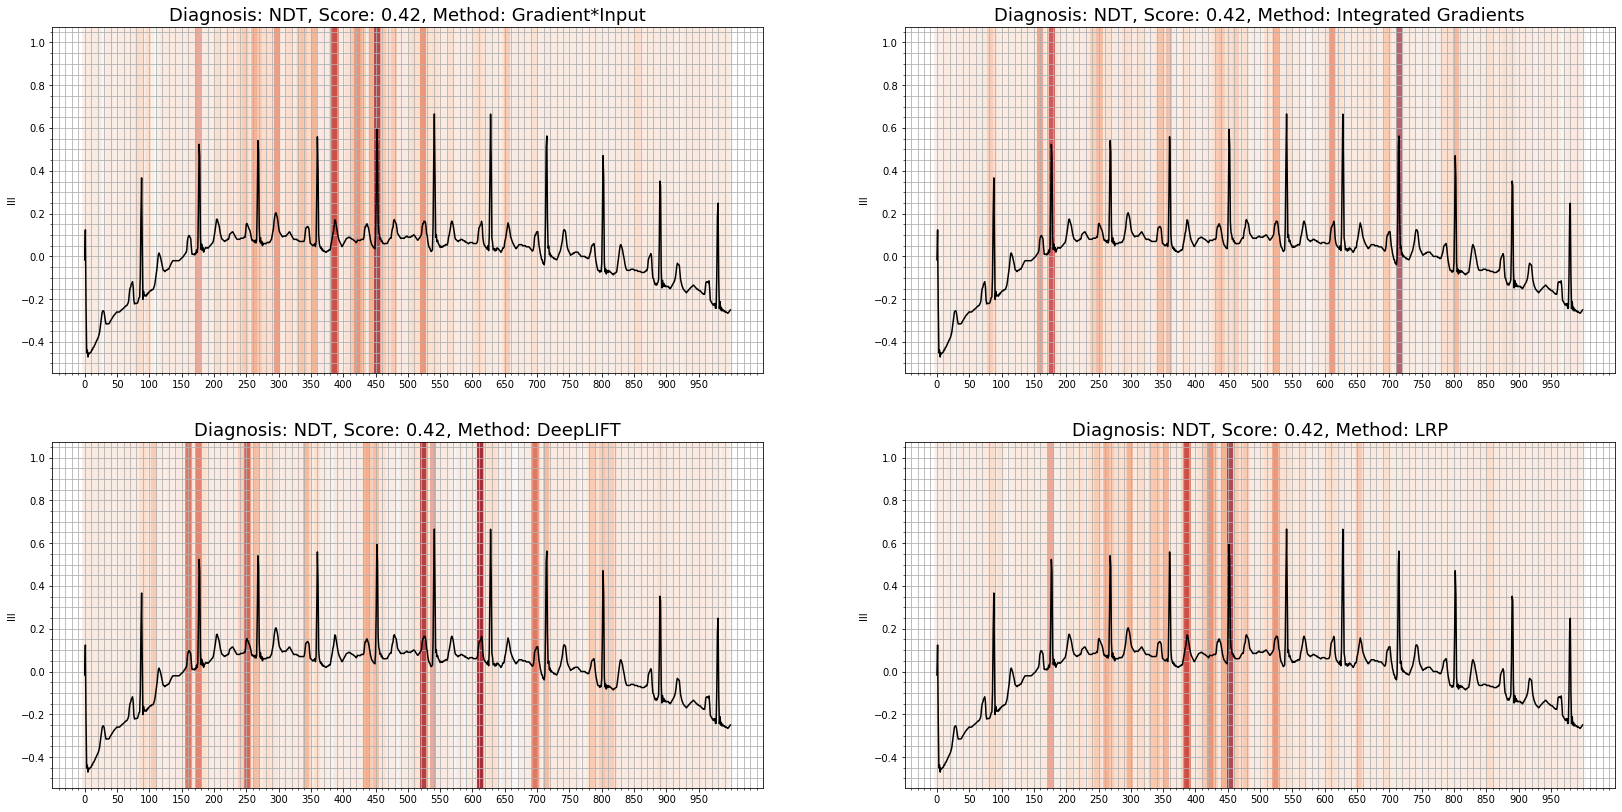

In [ ]:
interpretation(attr, x_test_reshaped, leads, 'III', pred_class, score, n_ecg, 'unet')